In [31]:
import numpy as np 
import pandas as pd 
import cv2
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.feature import hog
import os
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
from os import getenv
from dotenv import load_dotenv  # pipenv install python-dotenv

load_dotenv()

SVM_HOG_PREDICTOR = getenv("SVM_HOG_PREDICTOR")
PCA_REDUCER = getenv("PCA_REDUCER")
LABEL_ENCODER = getenv("LABEL_ENCODER")
DATASET_DIR = getenv("DATASET_DIR")

In [3]:
t1=time.time()
height=128
width=64
data=[]
labels=[]
Celebs=[]

In [4]:
for dirname,_, filenames in tqdm(os.walk(DATASET_DIR)):
    for filename in filenames:
        image = cv2.imread(os.path.join(dirname, filename))
        image= cv2.resize(image , (width, height))
        labels.append(dirname.split("/")[-1])
        data.append(image)

7it [00:00, 30.30it/s]


In [ ]:
fig = plt.figure(figsize=(20,15))

for i in range(1, 10):
    index = random.randint(0, 120) #https://www.pythoncentral.io/how-to-generate-a-random-number-in-python/
    plt.subplot(3,3, i)
    plt.imshow(data[index])
    plt.xlabel(labels[index].split("_")[0])
plt.show()

>  CODIFICAMOS LAS ETIQUETAS

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Labels= le.fit_transform(labels)

In [34]:
le.classes_

array(['Angelica', 'Brando', 'Diego', 'Julissa', 'Nelson', 'Wiki'],
      dtype='<U8')

>  CONVERTIMOS LAS IMAGENES A ESCALA DE GRISES

In [14]:
data_gray = [cv2.cvtColor(data[i] , cv2.COLOR_BGR2GRAY) for i in range(len(data))]

In [ ]:
fig = plt.figure(figsize=(20,15))

for i in range(1,10):
    index = random.randint(1, 120) #https://www.pythoncentral.io/how-to-generate-a-random-number-in-python/
    plt.subplot(3,3, i)
    plt.imshow(data_gray[index])
    plt.xlabel(Labels[index])
plt.show()

In [17]:
Labels = np.array(Labels).reshape(len(Labels), 1)

>  ## Descriptor HOG

Veamos algunos aspectos importantes de HOG que lo diferencian de otros descriptores de funciones:

* El descriptor HOG se centra en la estructura o forma de un objeto. Ahora podría preguntar, ¿en qué se diferencia esto de las características de borde que extraemos para las imágenes? En el caso de las entidades de borde, solo identificamos si el píxel es un borde o no. **HOG también puede proporcionar la dirección de los bordes.** Esto se hace extrayendo el gradiente y la orientación (o puede decir la magnitud y la dirección) de los bordes.
* Además, estas orientaciones se calculan en porciones **"localizadas"**. Esto significa que la imagen completa se divide en regiones más pequeñas y para cada región, se calculan los gradientes y la orientación. Discutiremos esto con mucho más detalle en las próximas secciones.
* Finalmente, el HOG generaría un **Histograma** para cada una de estas regiones por separado. Los histogramas se crean utilizando los gradientes y orientaciones de los valores de píxeles, de ahí el nombre "Histograma de gradientes orientados".


[TEORÍA](https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/)

Utilizando la función HOG de skimage.

*  Si configuras el parámetro ‘visualize = True’, devolverá una imagen del HOG.

+++++++ ======================================================= ++++++++

Antes de continuar, permítame darle una idea básica de lo que representa cada uno de estos hiperparámetros.
* Las orientaciones son la cantidad de cubos que queremos crear. Como quiero tener una matriz de 9 x 1, estableceré las orientaciones en 9

* pixels_per_cell define el tamaño de la celda para la que creamos los histogramas. Usamos 8 x 8 celdas y puede elegir cambiar este valor.

* Tenemos otro hiperparámetro cell_per_block que es el tamaño del bloque sobre el cual normalizamos el histograma. Aquí, mencionamos las celdas por bloque y no el número de píxeles. Entonces, en lugar de escribir 32 x 32, usaremos 2 x 2 aquí.

In [18]:
ppc =8
cb=4
hog_features=[]
hog_image=[]
for image in tqdm(data_gray):
    fd , hogim = hog(image , orientations=9 , pixels_per_cell=(ppc, ppc) , block_norm='L2' , cells_per_block=(cb,cb) , visualize=True)
    hog_image.append(hogim)
    hog_features.append(fd)

100%|██████████| 170/170 [00:02<00:00, 70.86it/s]


> VISUALIZACIÓN DE IMÁGENES HOG

/home/hiroforyou/.local/share/virtualenvs/TRABAJOS-SkxOZd0Z/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


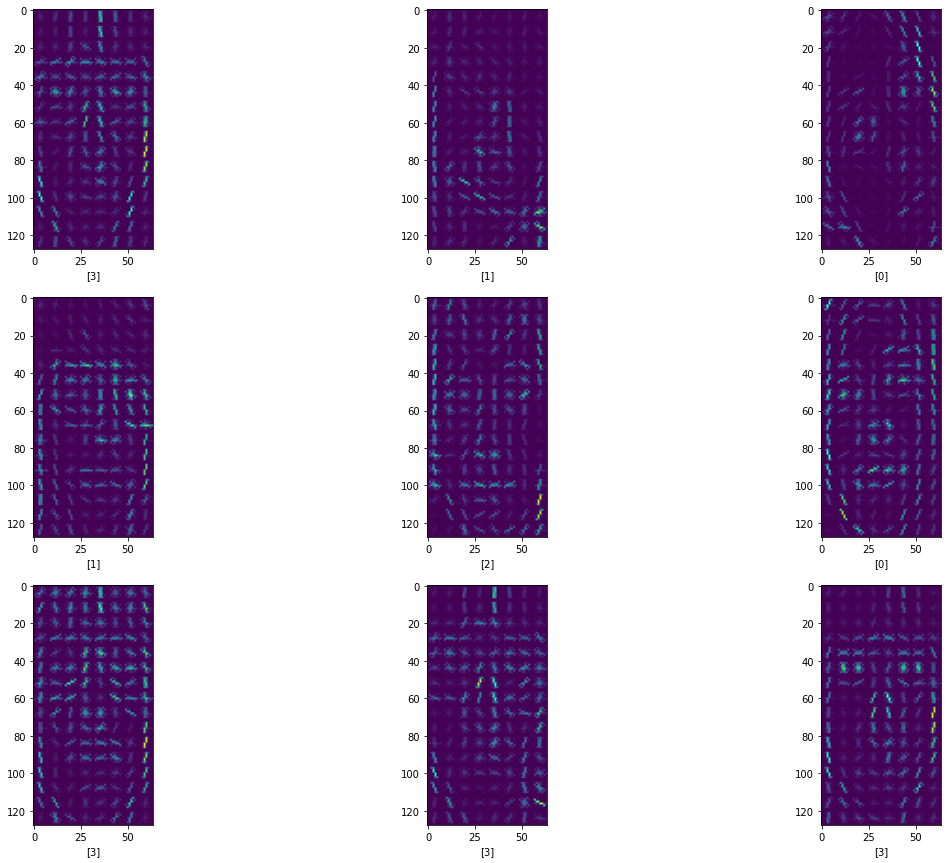

In [20]:
fig = plt.figure(figsize=(20,15))

for i in range(1,10):
    index = random.randint(1, 120)
    plt.subplot(3,3,i)
    plt.imshow(hog_image[index])
    plt.xlabel(Labels[index])
plt.show()

>  ## Creando un modelo SVC para entrenar

In [21]:
hog_features = np.array(hog_features)
df = np.hstack((hog_features, Labels))

In [22]:
X_train , X_test , Y_train , Y_test = train_test_split(df[:,:-1] ,
                                                       df[:,-1], 
                                                       test_size=0.3 , 
                                                       random_state=0 , 
                                                       stratify=df[:,-1])

>  Usando PCA para la reducción de la dimensionalidad

In [26]:
from sklearn.decomposition import PCA
t= time.time()
pca = PCA(n_components=100 , svd_solver='randomized' , whiten=True).fit(X_train)
print("Tiempo total", time.time()-t)

Tiempo total 1.3424787521362305


In [27]:
print("Proyectando los datos de entrada sobre una base ortonormal")
t0 = time.time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Hecho en %0.3fs" % (time.time() - t0))

Proyectando los datos de entrada sobre una base ortonormal
Hecho en 0.023s


In [28]:
t3=time.time()
svm = SVC(kernel='rbf' , class_weight='balanced' , C=1000 , gamma=0.0082)
svm.fit(X_train_pca , Y_train)
print(svm.score(X_test_pca , Y_test))
print("Hecho en %0.3fs" % (time.time() - t3))

0.45098039215686275
Hecho en 0.006s


In [29]:

print("Tiempo total", (time.time()-t1))

Tiempo total 313.23323345184326


In [35]:
pickle.dump(svm, open(SVM_HOG_PREDICTOR, 'wb'))

pickle.dump(pca, open(PCA_REDUCER, 'wb'))

pickle.dump(le, open(LABEL_ENCODER, 'wb'))